# Conditional Deep Convolutional Generative Adversarial Network (cDCGAN)

## Abstract
For this assignment, I decided to build a conditional DCGAN (cDCGAN) to generate images based on their class labels. The conditional GAN was first suggested by Mirza and Osindero (2014), and embeds class labels, $y$, of a given dataset, $x$, into both the discriminator and generator of the GAN to enable the creation of targeted images. The generated image results showed high in-class diversity but low inter-class diversity among both models, with the inter-class diversity being lower in the novel dataset model vs CIFAR10 model. The issue of inter-class mode collapse is hypothesized to be a result of both the underlying data and the model's architectural weaknesses. Potential solutions are suggested for future iterations.


## Introduction

According to Mirza and Osindero (2014), "Generative adversarial nets can be extended to a conditional model if both the generator and discriminator are conditioned on some extra information $y$. $y$ could be any kind of auxiliary information,
such as class labels or data from other modalities. We can perform the conditioning by feeding $y$ into both the discriminator and generator as additional input layer."

Some motivations for including the class label within the input are (Brownlee, 2019):

- To improve GAN performance by making use of additional information (class labels) that is correlated with the input images.

- To generate targeted images.

## Encoding Class Labels

In a vanilla conditional GAN network with linear layers, $y$ could be embedded into the input via simple concatenation. According to Brownlee (2019), one of the best practices in encoding and incorporating class labels into both the discriminator and generator models entails "using an embedding layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map".

In a conditional DCGAN network with convolutional layers, the encoding of class labels becomes a bit trickier since the images are not flattened into a single dimension before being fed into the network. Instead, the DCGAN network normally takes in an input of 3 dimensions, i.e. width x heights x number of channels. The image is then continuously convolved through multiple kernels in the network without ever having to be flattened until a final classification decision has to be made using a linear layer (e.g. sigmoid) at the output. 

## Main References

To build my cDCGAN model, I made heavy reference of the following sources:

- **Pytorch DCGAN Tutorial (Inkawhich, 2017).** The tutorial walked through the concept and implementation of the DCGAN model in Pytorch.


- **Conditional GAN Code in Pytorch (Linder-Noren, 2019).** This Github repo covers the implementation of a regular conditional GAN model. Linder-Noren made use of Pytorch's `nn.Embedding` layer to embed the class labels in the model. He concatenated the embedding layer with the flattened input before feeding it into the GAN network. Since I was using a conditional DCGAN, I could only borrow his idea of using a `nn.Embedding` layer but still needed to figure out an appropriate location in the architecture where I could embed my class labels.


- **Conditional DCGAN Tutorial in Keras (Desai, 2018).** This Medium post walked through the implementation of a conditional DCGAN in Keras. Desai noted that "It wasn’t really intuitive ... how the conditioning input can be applied to the Convolutional layers of the Discriminator", but ultimately justified concatenating the labels right before the fully connected layers (near the end of the network) on the basis that "the Discriminator is learning high level features from the image and using them in conjunction with the conditioning input to make the final decision". This was the method I used to embed my class labels in my cDCGAN model.


- **cGAN and cDCGAN on MNIST and Celeb Faces in Pytorch (Kang, 2017).** This Github repo implements both a conditional GAN and conditional DCGAN in Pytorch to generate MNIST digits and celebrity faces. In contrast to Desai (2018), Kang (2017) embedded the class labels to the input very early on in the discriminator by first feeding the image and class labels seperately into the same convolutional layer, so that both the image and class labels have the same output shape after the first convolution. After that, the image and class labels are concatenated together and fed through the rest of the network. The figure below illustrates Kang's methodology:

<img src='kang-cdcgan.png' style='width:75%'>

## Architectural Choices

### Conditional Discriminator

My biggest challenge in building the conditional discriminator was deciding on how to embed the class labels into the network. Linder-Noren (2019) simply concatenated the class labels with the input before feeding it into the network, but he could do so because he was using a regular conditional GAN without convolutional layers. Convolutional layers take in multidimensional inputs, and so the concatenation of class labels is not as straightforward as if the input was 1-dimensional.

The two main ways of embedding class labels that I considered were:

- Kang's (2017) method of embedding the class labels to the image after feeding both through a convolutional layer. This means the image was "conditioned" on the class before going through the main convolutional layers.


- Desai's (2018) method of embedding the class labels to the image after the convolutional layers, but before the input is fed into the linear layers section of the network. That is, given a conventional deep CNN model structured as `INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC` (Karpathy & Johnson, 2017), the class labels will be concatenated after the `CONV` block but before the `FC` layers.

I decided to follow Desai's (2018) method as I liked his reasoning that the class label should be considered a "higher-level" feature that would be embedded near the tail-end of the conditional DCGAN to provide further information to the network.

**Convolutional Layers in Discriminator** - The convolutional layers of my discriminator were based on the Pytorch DCGAN tutorial (Inkawhich, 2017), which was in turn, based on the original DCGAN paper (Radford, Metz, & Chintala, 2015).

**Embedding the Class Label** - The output from the final convolutional layer was flattened and concatenated with the class label layer to create a "conditioned" layer of dimension: [batch size, number of classes + 1]. For example, with a batch size of 128 and 3 class labels, the convolutional layer output is flattened to [128, 1], the class labels are represented as an embedded layer of [128, 3], and so the concatenated layer is [128, 3+1] = [128, 4].

**Linear Layers in Discriminator**
The concatenated layer was then fed into a `FC -> LeakyRELU` block right before the final sigmoid layer. This was mostly just following Desai's (2018) architecture, with minor tweaking on my end to adjust the number of input and output features. I used 512 output features for the linear layer because that was the number used by both Desai (2018) and Linder-Noren (2017), though frankly I am uncertain as to whether there is a strong reason for choosing 512 as the number of neurons (other than the fact that 512 is a power of 2).

Since Desai's (2018) code was written in Keras, I followed his choice of concatenation placement, but referenced Linder-Noren's (2017) implementation of Pytorch's `nn.Embedding` layer to embed the class labels.

### Conditional Generator

The conditional generator was relatively simpler to implement. I followed Desai's (2018) method of first concatenating the class labels with the input noise to produce a 1D input, before reshaping the 1D input into a 3D input with dimensions [latent vector size + number of class labels, 1, 1]. This 3D input was then fed into the convolutional layers to generate a fake image.

### Complete Conditional Model

The complete model is similar to the DCGAN model, except that an additional class label input is now fed into both the discriminator and the generator to be embedded and used within the network.

Aside from adding class labels as an additional parameter, an additional step was to generate fake labels for generating fake images and training the discriminator on the fake images:

`generated_labels = torch.randint(self.n_classes, (b_size,)).type(torch.LongTensor)`

where `n_classes` is the number of classes, and `b_size` is the batch size. The output is a 1D tensor of size `[b_size]` that contains a random uniform distribution of each class label (since number of classes is the class label ceiling).


## Data

Two datasets were used to test the efficacy of the cDCGAN: the CIFAR10 dataset and a custom dataset.

The CIFAR10 dataset consisted of 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 50,000 images were used to train the cDCGAN, with an even distribution of 5,000 images per class.

The custom dataset consisted of 3 classes: cartoon, cyberpunk, and noir digital artwork. The digital art was scraped from https://www.artstation.com/. The classes have 9924, 9859, and 3567 entries respectively. 


## Parameter Values

Most parameters were set according to the Pytorch tutorial on building a DCGAN model. The following custom adjustments were also carried out:

- The images were resized to (32, 32, 3) for faster computation, and the feature map size for both the generator and the discriminator were also set to 32. 

- The batch size was set to 128.

## Implementation

The cDCGAN was trained for 60 epochs on the CIFAR10 dataset and 60 epochs on the novel dataset. The parameters were kept the same across both training procedures, aside from the dataloaders.


### Training Process

The training process was carried out as follows:

1) Initiailize cDCGAN object with designated parameters.

2) Train for a set number of epochs. The model automatically saves checkpoints at every 5 epochs, as well as after the last epoch.

3) If more training is desired, load model from last epoch to continue training.


## Results and Analysis

Note that in order to run the cells containing the `plot_gen_images()` and `plot_progression()` functions to visualize the results, the cells below in the **Code** section have to be run first to create the model objects, load checkpoints (if applicable), and define the functions. I just shifted the functions up here so that the results can be seen before the analysis.

### CIFAR10 Model Results

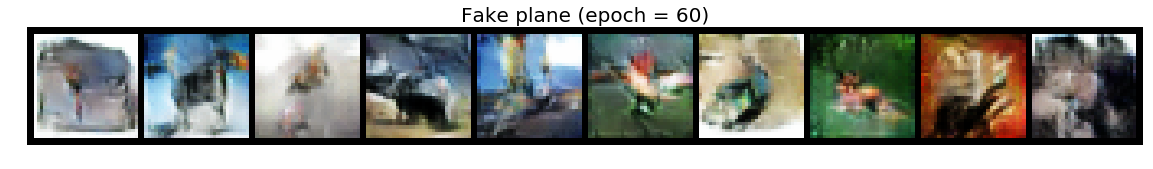

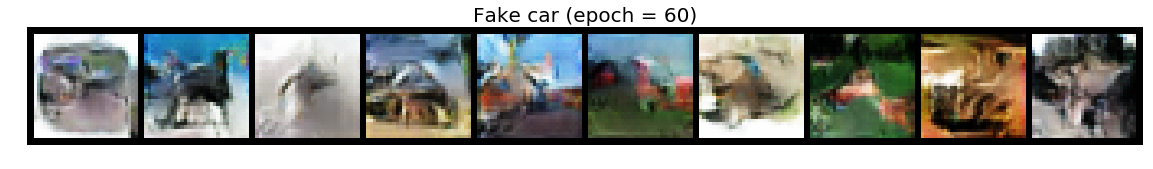

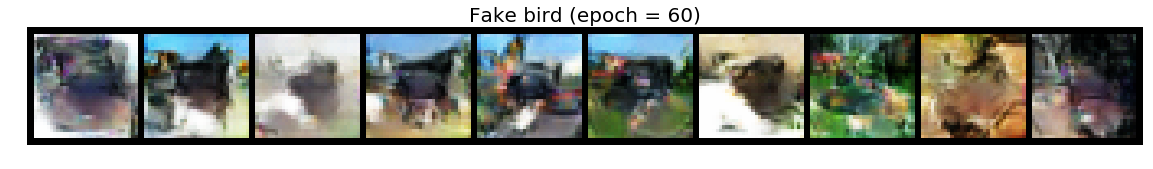

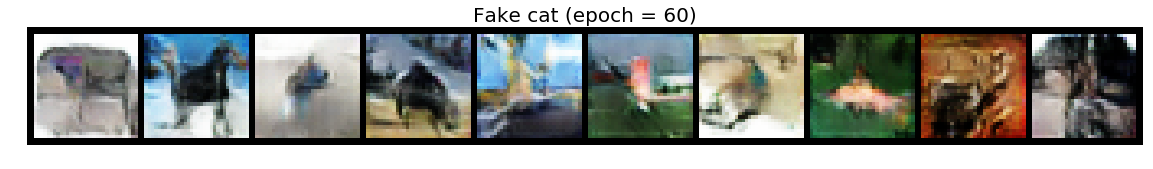

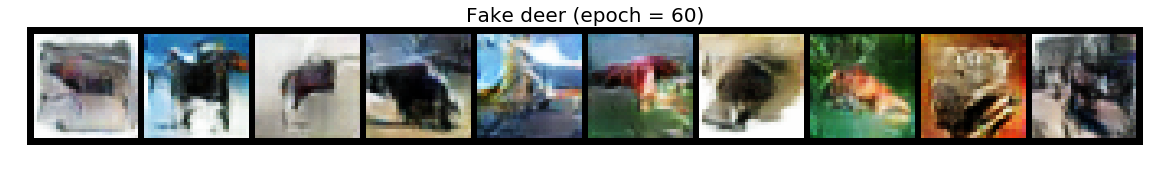

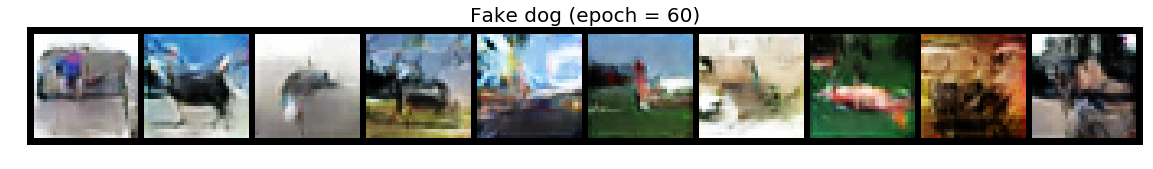

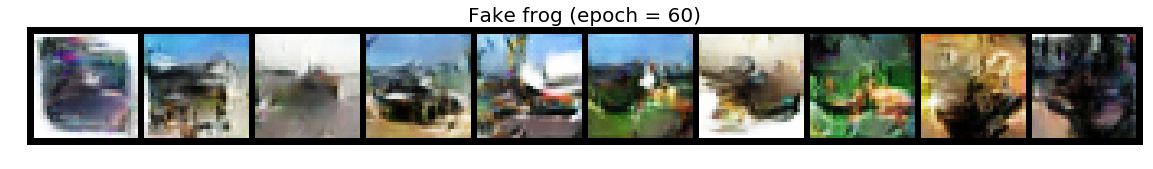

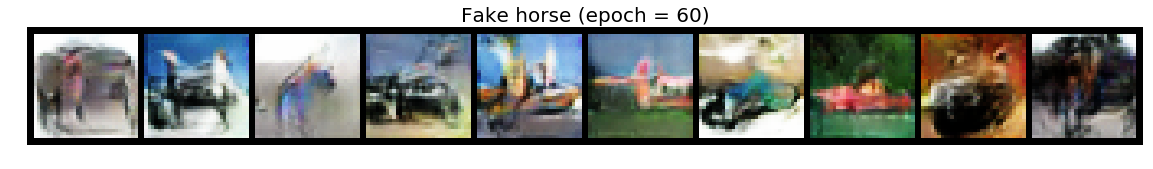

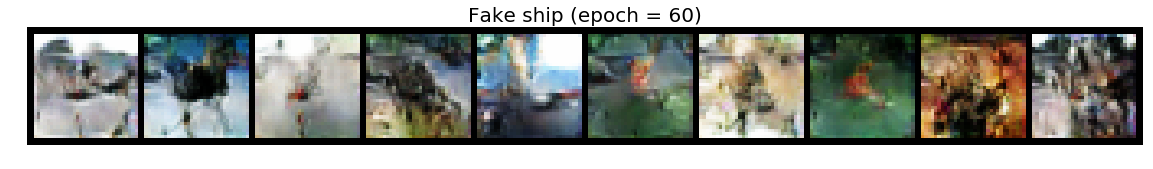

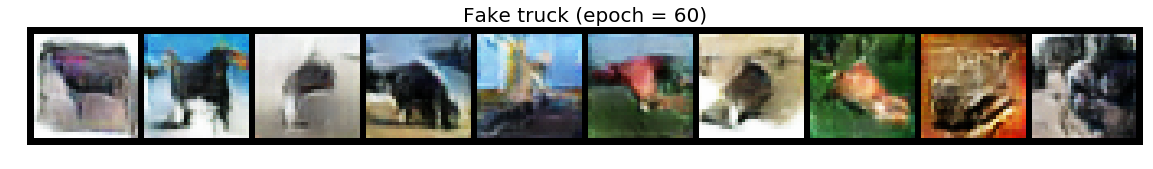

In [293]:
plot_gen_images(cifar_classes, cdcgan_cifar)

### Generator Progression for "Dog" Class

I decided to only show the progression for a single class since there is low inter-class diversity, so the progression does not differ significantly between classes anyway.

There are 50 images to be plotted. Adjust params accordingly.


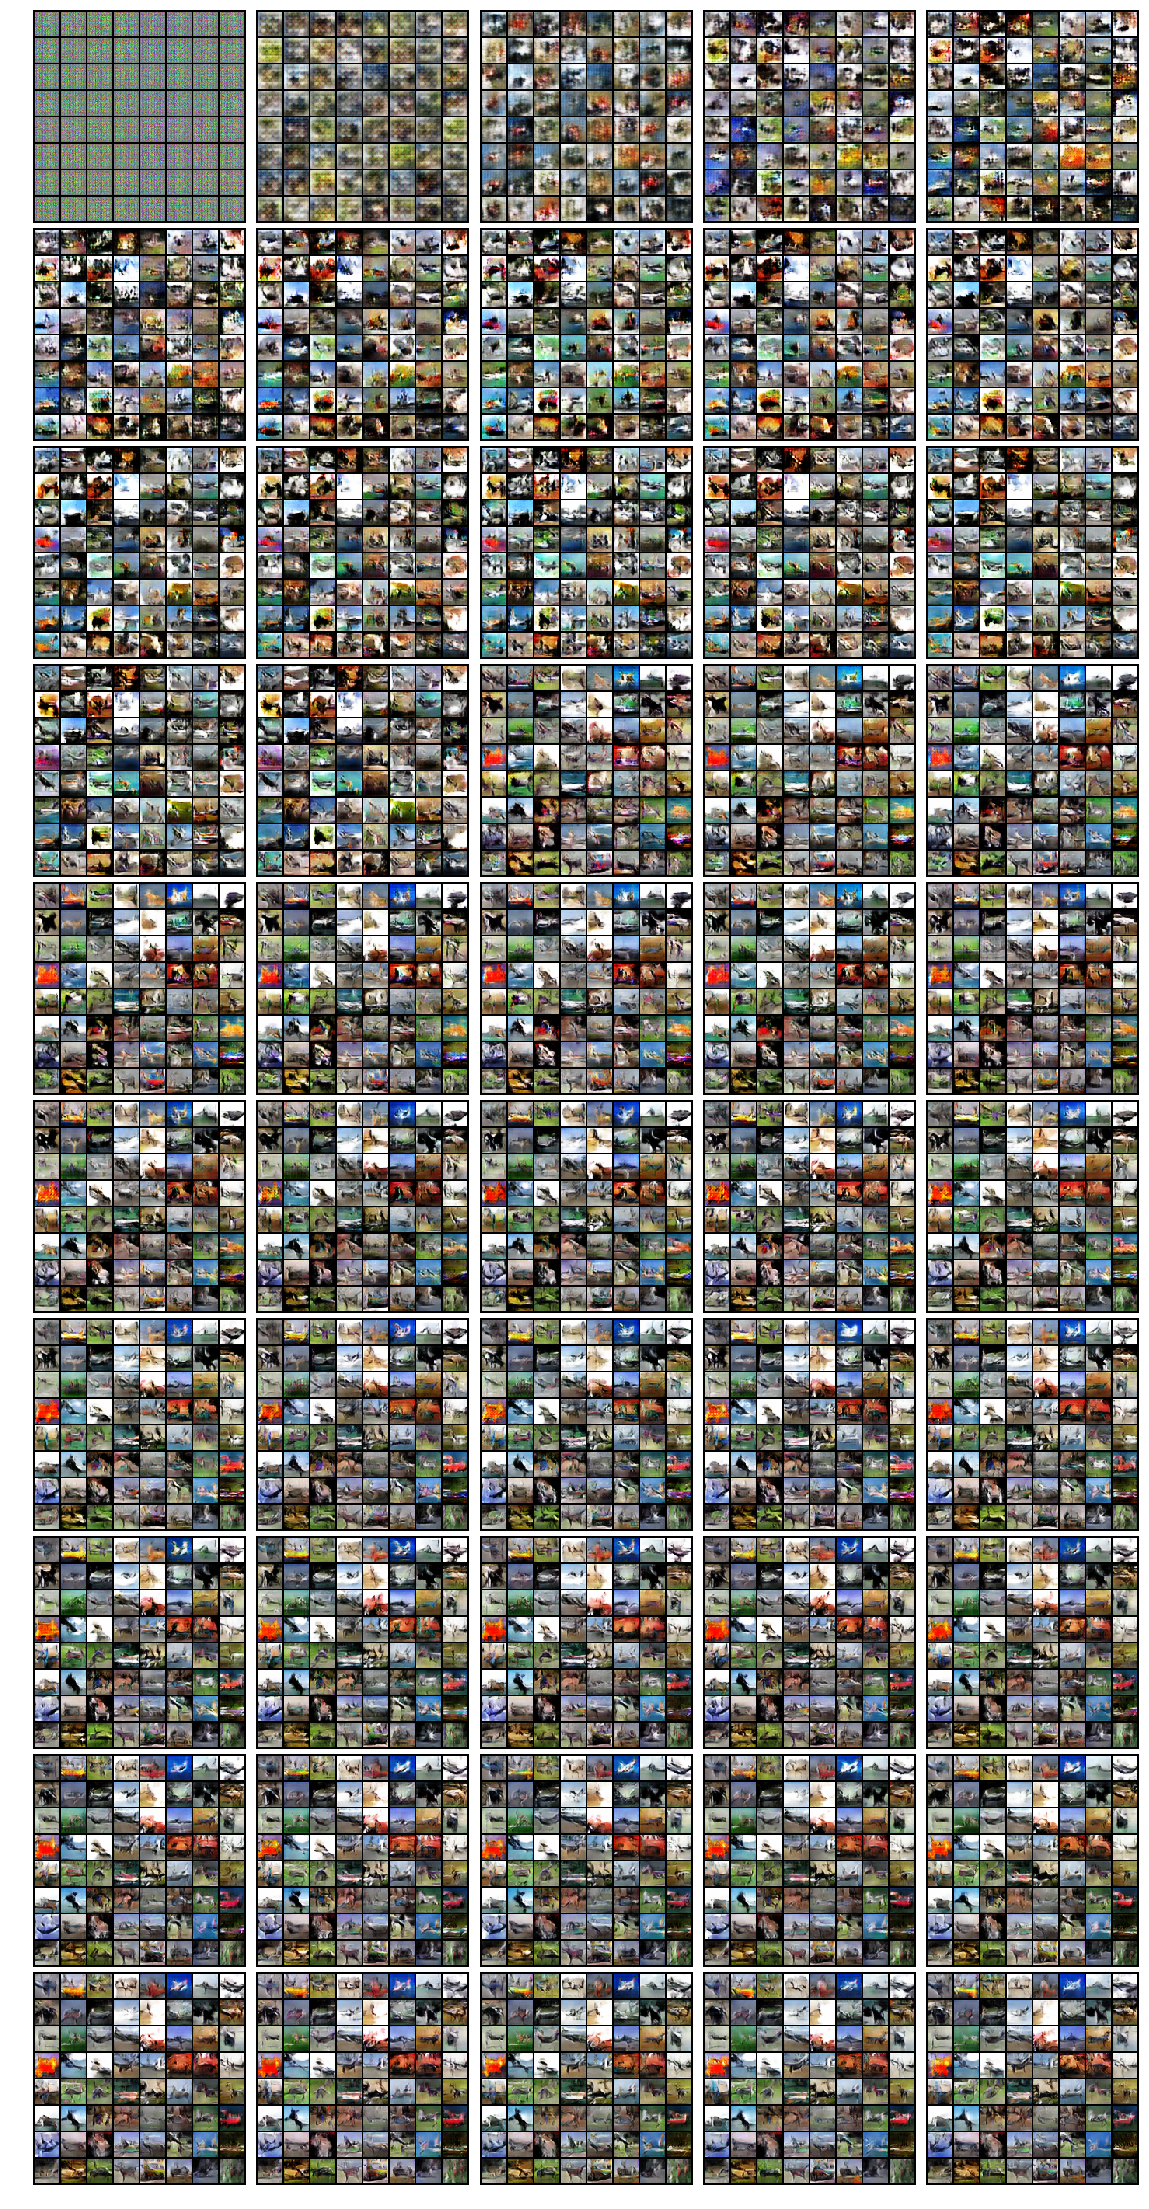

In [271]:
plot_progression('cDCGAN-cifar/fake_images/', 'dog', fig_w = 20, fig_h = 40, nrows = 10, ncols = 5)

### CIFAR10 Model Analysis

The cDCGAN model trained on the CIFAR10 dataset is able to generate a decent variety of fake images within a single class, which suggests that the within-class mode is not collapsing. Regarding the inter-class variation, we can see some visual differences across the different class images, but it is definitely not obvious enough that one could differentiate the classes from each other unless through careful scrutiny and cherry-picking.

It would appear that my model's generator has learned to create a certain type of fake image that can be considered valid for a high variety of classes, i.e. it is defaulting to a mode in the image-validity distribution, and is collapsing to that mode.

The mode collapse is visualized as generated images that look similar across the different classes. For example, most of the fake images look similar, despite being generated for different classes. The "frog" and "ship" classes do have some visual characteristics that allow me to pick them out if I squint very hard, but it's all rather hacky. The "ship" images all come with a "wavy" blur, perhaps due to the presence of water in real ship images. The "frog" images tend to have a semi-curved bottom border filled with white - at first I thought this was because of the frog's belly, but when I analyzed the real images I saw that most frog pictures featured a frog against a white backdrop (unlike the other images which almost always had a filled natural background). I think this reinforces the idea that the underlying data quality can have a huge impact on the cDCGAN performance.

While my generated images look a far stretch from the real images, and honestly look very similar across classes, the fact that _some_ of the classes appear to have developed _some_ distinctive (albeit unexpected) visual features that allow them to be distinguished from the other classes suggests that my cDCGAN model is capable of creating targeted images given sufficient inter-class variation within the underlying data or with further improvement to the model to tackle mode collapse.

I also suspect the possibility that the underlying dataset (CIFAR10) may simply have small inter-class variation between certain classes in particular, and so we see mode collapse across these classes, but successful targeted generation across classes that inherently had highly differentiated visual features. In his report on GANs, Goodfellow (2016) stated that Minibatch GANs are able to create rather distinguishable targeted images when trained on the CIFAR10 dataset, though to be honest his generated images still look rather similar and undistinguishable to me. The thing is, my model is also capable of creating "horse-like" images; the problem is the horse-like image is undistinguishable from a dog-like or cat-like image.


 <img src="goodfellow-cifar10.png" style="width:75%">


### Novel Dataset Model Results

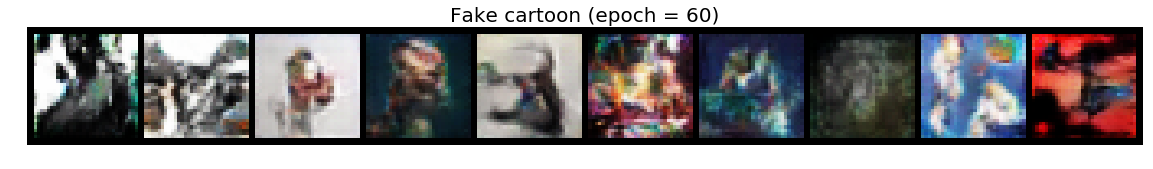

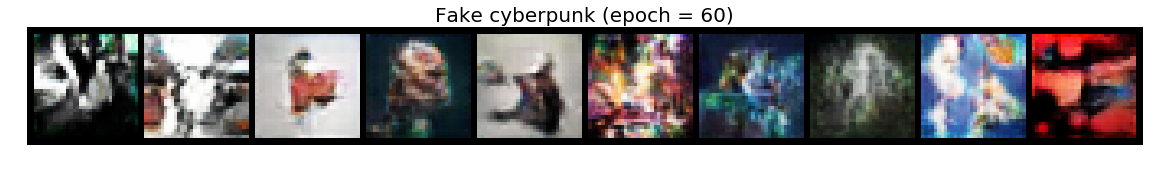

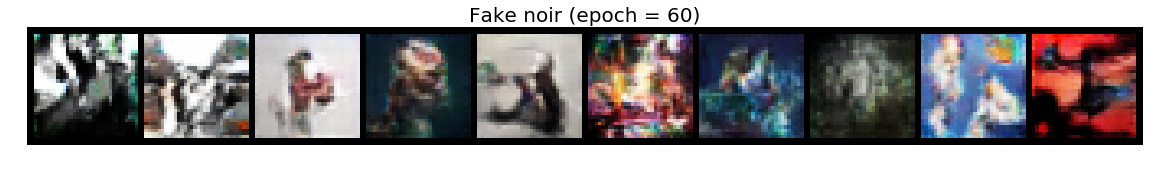

In [272]:
plot_gen_images(dataset.classes, cdcgan)

### Generator Progression for "Cyberpunk" Class

I started testing out my cDCGAN on the novel dataset, so the image progression plot differs slightly from how I presented it for the CIFAR10 dataset. Specifically:

- I generated only 10 images per epoch instead of 64, and so a row of images is created vs a full grid. 
- I changed the latent noise vector $z$ around the 10th epoch of training, so the generated images for epochs 1, 3, 6, and 9 are rendered irrelevant in visualizing the progression of the generator. As such, I have not included them in the plot below. The first row of images below starts from epoch 11, and the last row marks epoch 60.

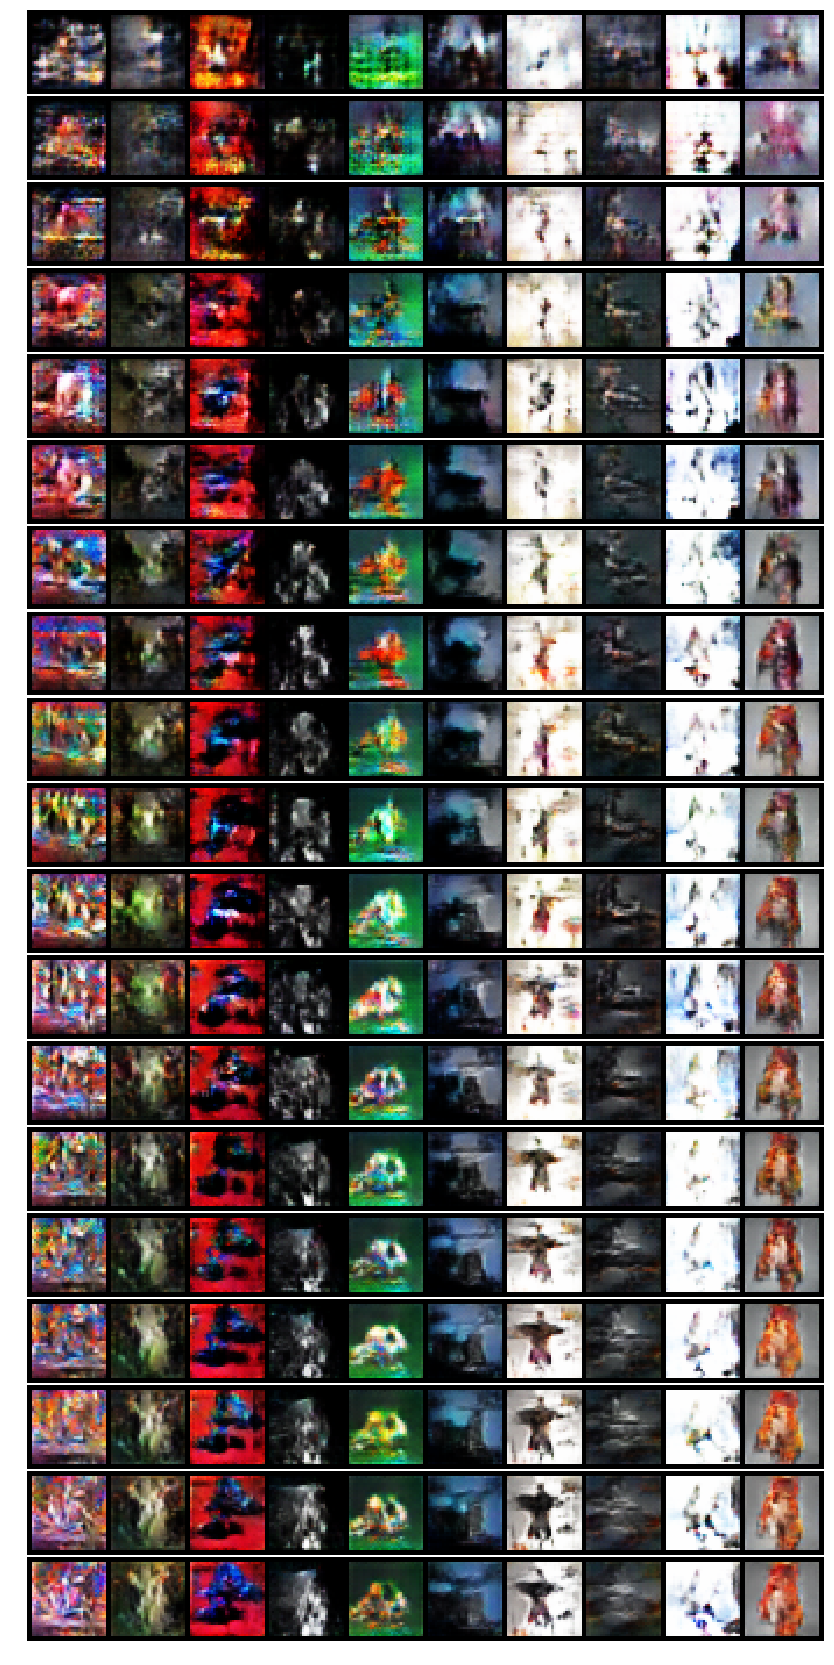

In [284]:
plot_progression('cDCGAN/fake_images/', 'cyberpunk', fig_w = 40, fig_h = 30, nrows = 19, ncols = 1)

### Novel Dataset Model Analysis

For the cDCGAN model trained on my novel dataset, we see that the batch of generated images for any given class looks sufficiently varied, but a comparison of the generated images across different classes bears little to no visual difference. The difference is even harder to detect for the novel dataset model vs the CIFAR10 model, but this could be because the data is inherently less varied (there is a high possibility of high overlap between cyberpunk, cartoon, and noir type artwork). That being said, if you squint really hard, there are actually some slight color variation differences.

On hindsight, the imbalance in the class label numbers may also have contributed to mode collapse in the model, but I did not want to balance the classes since that would result in cutting roughly 60% of the cartoon and cyberpunk classes. Since I was building a GAN, I figured that the class imbalance was acceptable. However, the embedding of class labels in the input may have caused the class imbalance to negatively affect the model's performance.

## Mode Collapse

Goodfellow (2016) defined mode collapse as "a problem that occurs when the generator learns to map several different input $z$ values to the same output point." Real world data usually consists of multimodal distributions, e.g. there are usually several common features that we expect to see in an image belonging to a given class. If the generator is somehow able to identify one of the distribution modes and the discriminator has not been trained well, it will fail to recognize that the generated data is simply coming from a single mode (Desai, 2018). Within the cDCGAN, this is represented as low inter-class variation since the generator can fall back on common modes among different classes, e.g. the color blue (if most class images contain a sky), high contrast colors (this can be seen in my novel dataset, where most artists like to draw high-contrast images regardless of the genre). 

## Future Work

There are a few suggested solutions for reducing mode collapse in GANs. I have listed some here to be potentially explored in future work, but unfortunately did not implement these solutions in this paper due to time constraints.

- **Minibatch Discrimination (Salimans et al., 2016 as cited in Goodfellow, 2016)**. In minibatch discrimination, the generator is penalized for generating similar looking samples. Real images and generated images are fed into the discriminator separately in different batches; the similarity of the image x with images in the same batch is then computed as a similarity term, $o(x)$. $o(x)$ is then concatenated in one of the dense layers in the discriminator to classify whether this image is real or generated. If the mode starts to collapse, the similarity of generated images increases. The discriminator can then use the similarity score $o(x)$ to detect generated images and penalize the generator if mode is collapsing.


- **Unrolled GANs (Metz et al., 2016 as cited in Goodfellow, 2016)**. As explained by Goodfellow (2016): "The idea of unrolled GANs is to build a computational graph describing $k$ steps of learning
in the discriminator, then backpropagate through all $k$ of these steps of learning
when computing the gradient on the generator. Fully maximizing the value
function for the discriminator takes tens of thousands of steps, but Metz et al.
(2016) found that unrolling for even small numbers of steps, like 10 or fewer, can
noticeably reduce the mode dropping problem." The $k$-step lookahead discourages the generator from exploiting a local optima that could easily be counteracted by the discriminator, and so unrolled GANs reduce the probability of the generator overfitting to a specific discriminator (Hui, 2018).

# Code

## Import Libraries

In [240]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from torchsummary import summary
from torchvision.utils import save_image
import torchvision

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Set Parameter Values

In [2]:
# Root directory for dataset
dataroot = 'images'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Import Data


In [3]:
def plot_images(dataloader, classes, image_number = 8, model = None):
    
    '''
    Function to plot a sample of images from the dataloader, alongside their class labels.
    If a model is assigned to the model parameter, the predicted labels will be printed as well.
    
    Input:
        dataloader (DATALOADER)
            Dataloader of dataset.
            
        classes (ARR)
            Array type object containing the class labels (strings) in the order that 
            corresponds with the numerical key in the dataloader.
        
        image_number (INT)
            Number of images to plot from the dataloader. image_number should not exceed batch size.
            Since images are plotted in a row, any number > 10 could cause display issues.
            Default: 8.
        
        model (PYTORCH MODEL)
            Optional parameter. If a model is provided, the predicted labels from the 
            model for each of the images will be printed as well. 
            Default: None.
    '''
    
    # get images and true labels
    images, labels = next(iter(dataloader))

    # plot images
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:image_number], padding=1, normalize=True).cpu(),(1,2,0)))
    
    # print true labels
    print('True labels: ', '     '.join('%5s' % classes[labels[j]] for j in range(image_number)))
    
    if model:
        # predict image classes using custom net
        outputs = model(images)
        # the outputs are energies for the 10 classes. 
        # the higher the energy for a class, the more the network thinks that the image is of the particular class.
        # So, we get the index of the highest energy:
        _, predicted = torch.max(outputs, 1)
        # print predicted labels
        print('Predicted:  ', '   '.join('%5s' % classes[predicted[j]] for j in range(image_number)))


def get_target_index(dataset):
    '''
    Given a dataset, this function returns a dictionary of classes, where the value of each class 
    is a dictionary containing the class indices and the number of datapoints in the class.
    
    Input:
        dataset (IMAGEFOLDER)
            Dataset should be ImageFolder class.
        
    Output:
        idx_dct (DCT)
            Nested dictionary with the class name as key, and a dictionary containing the
            'indices' and 'length' of the class as values.
            Example format:
            idx_dct = { 'class_A':{
                        'indices': [1,2,3,4,5],
                        'length': 5
                        },
                        'class_B':{
                        'indices': [6,7,8],
                        'length': 3
                        },
                        'class_C':{
                        'indices': [100,101,102,103],
                        'length': 4
                        }}
    '''
    targets = torch.tensor([t[1] for t in dataset.samples])
    idx_dct = {}
    
    for k,v in dataset.class_to_idx.items():
        idx_dct[k] = {'indices': (targets == v).nonzero().reshape(-1)}
        idx_dct[k]['length'] = len(idx_dct[k]['indices'])
        
    return idx_dct


def plot_batch(dataloader):    
    '''
    Plot images from a dataloader
    '''
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    

## CIFAR10 Dataset

Files already downloaded and verified
True labels:   bird      ship      deer       dog      deer       cat     horse      bird


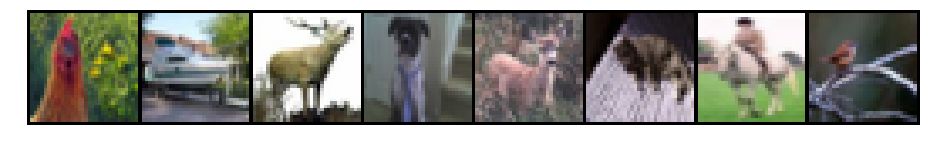

In [75]:
# transform images to tensor and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# create dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifar_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# plot sample of images
plot_images(trainloader, classes)

## Novel Dataset

Class cartoon has 9924 entries.
Class cyberpunk has 9859 entries.
Class noir has 3567 entries.
True labels:  cyberpunk     cyberpunk     cartoon     cartoon     cartoon     cartoon      noir     cartoon


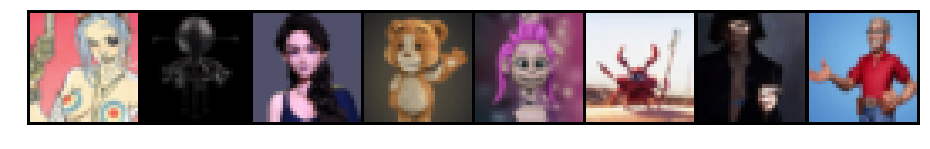

In [4]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

target_idx_dct = get_target_index(dataset)
for k,v in target_idx_dct.items():
    print(f"Class {k} has {v['length']} entries.")

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

plot_images(dataloader, dataset.classes, image_number = 8)

## cDCGAN Model

In [74]:
def weights_init(m):
    '''
    Custom weights initialization called on netG and netD
    '''
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [97]:
class cDiscriminator(nn.Module):
    
    def __init__(self, n_classes, ngpu):
        
        super(cDiscriminator, self).__init__()
        
        self.ngpu = ngpu
        
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.convolution_layers = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            # nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ndf * 8),
            # nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        )
        
        self.linear_layers = nn.Sequential(
            
            nn.Linear(in_features = 1 + n_classes, # flattened output from last conv + embedding
                      out_features = 512), # arbitrary + based on external references
            
            nn.LeakyReLU(0.2, inplace=True) ,
        
            nn.Linear(in_features = 512, # output from last linear layer
                      out_features = 1), # true or false image
            
            nn.Sigmoid()
        )
        

    def forward(self, input, labels):
        
        x = self.convolution_layers(input) # run input through convolutional layers
        # print(x.shape) # output shape: (128,1,1,1)
        x = x.view(x.size(0), -1) # flatten output from main
        # print(x.shape) # output shape: (128,1)
        y = self.label_embedding(labels) # create label layer
        # print(y.shape) # output shape: (128,3)
        x = torch.cat((x, y), -1) # concatenate flattened output to label layer
        # print(x.shape) # output shape: (128,4)
        x = self.linear_layers(x) # run flattened + merged layer through linear layers
        
        return x
    

In [98]:
# Generator Code

class cGenerator(nn.Module):
    
    def __init__(self, n_classes, ngpu):
        
        super(cGenerator, self).__init__()
        
        self.ngpu = ngpu
        
        self.n_classes = n_classes
        
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        self.main = nn.Sequential(
            
            # input is Z + n_classes, going into a convolution
            nn.ConvTranspose2d(nz + n_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            # nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input, labels):
    
        # Concatenate label embedding and noise to produce input
        flat_embed_input = torch.cat((self.label_emb(labels), input), -1)

        # reshape flattened layer to torch.Size([128, nz+n_classes, 1, 1])
        reshaped_input = flat_embed_input.view((-1,nz + self.n_classes,1,1)) 
        
        gen_img = self.main(reshaped_input)
        
        return gen_img
  

In [143]:
class cDCGAN(object):
    
    '''
    Conditional DCGAN class.
    '''
    
    def _checkDirectory(self, dirName):
        
        if not os.path.exists(dirName):
            print(f"{dirName} directory does not exist. Making {dirName}")
            os.makedirs(dirName)
            
        else: print(f"{dirName} directory exists.")
    
    
    def __init__(self, dataloader, classes, save_dir, num_epochs,
                 criterion, netD, netG, optimizerD, optimizerG, device):
        
        # data parameters
        self.dataloader = dataloader
        self.classes = classes # class labels
        self.n_classes = len(classes) # number of classes
        
        # save file locations
        self._checkDirectory(save_dir) # check whether save dir exists
        self.checkpoint_dir = os.path.join(save_dir, 'checkpoints')
        self._checkDirectory(self.checkpoint_dir) # create checkpoints dir
        self.fake_image_dir = os.path.join(save_dir, 'fake_images')
        self._checkDirectory(self.fake_image_dir) # create fake images dir
        
        # model parameters
        self.num_epochs = num_epochs # number of epochs to train for
        self.start_epoch = 1 # the starting epoch
        self.criterion = criterion # loss function
        self.real_label = 1 # Establish convention for real and fake labels during training
        self.fake_label = 0

        # networks init
        self.netD = netD
        self.netG = netG
        self.optimizerD = optimizerD
        self.optimizerG = optimizerG
        
        # device
        self.device = device # specify device being used
        
        # Create fixed noise to visualize the progression of the generator
        self.fixed_noise = torch.randn(64, nz, device=self.device) # torch.Size([64, 100])
            
        
    def generate_fake_images(self, class_index_tensor, noise, image_name = 'random', save = True):
        
        '''
        Generate a batch of fake images using current generator weights.
        
        Inputs
        
            class_index_tensor (LongTensor)
                The class index to create fake images for. The number of fake images generated is equal
                to the length of the tensor. So a tensor filled with 10 "1"s will generate 10 images for
                the class that corresponds to "1".
                
            noise (Tensor)
                Random noise that will be put through the generator weights to produce an image.
        
            image_name (STR)
                Image name for the saved file.
                If running this function in model training, image_name should contain a changing variable,
                otherwise the files will just keep overwriting each other with the same name.
                Default: 'random' (in case save = True but no image_name provided)
            
            save (BOOL)
                If save is TRUE, the image file will be saved in the specified "self.fake_image_dir".
                Otherwise, just return the image data for plotting.
                Default: TRUE
            
        ''' 
        with torch.no_grad():
            # create fake images for a the labels in class_index_tensor
            fake = self.netG(noise, class_index_tensor).detach().cpu()
        
        if save: # save images in the fake_image_dir
            save_image(fake.data, f'{self.fake_image_dir}/{image_name}.png',
                       nrow=8, padding=2, normalize=True)
        
        return fake.data
    

    def train(self):
        
        '''
        Training loop
        '''
        if self.num_epochs == 0:
            print(f"No epochs set for training. Exiting training loop.")
            return
            
        # Lists to keep track of progress
        self.G_losses = [] # generator loss
        self.D_losses = [] # discriminator loss
        iters = 0

        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(self.start_epoch, self.start_epoch + self.num_epochs):
            # For each batch in the dataloader
            for i, (imgs, class_labels) in enumerate(self.dataloader):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################

                ## Train with all-real batch
                ###########################
                self.netD.zero_grad()

                # Format batch
                real_imgs = imgs.to(self.device)
                b_size = real_imgs.size(0)

                # Set ground truth labels as REAL
                validity_label = torch.full((b_size,), self.real_label, device=device)

                # Forward pass real batch through D
                output = self.netD(real_imgs, class_labels).view(-1)

                # Calculate loss on all-real batch
                errD_real = self.criterion(output, validity_label)

                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()


                ## Train with all-fake batch
                ###########################
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, device=device) # torch.Size([128, 10])

                # Generate batch of fake labels
                gen_labels = torch.randint(self.n_classes, (b_size,)).type(torch.LongTensor) # torch.Size([128, 3])

                # Generate fake image batch with G
                fake = self.netG(noise, gen_labels)

                # Update ground truth labels to FAKE
                validity_label.fill_(self.fake_label)

                # Classify all fake batch with D
                output = self.netD(fake.detach(), gen_labels).view(-1)

                # Calculate D's loss on the all-fake batch
                errD_fake = self.criterion(output, validity_label)

                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()

                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake

                # Update D
                self.optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################

                self.netG.zero_grad()

                validity_label.fill_(self.real_label)  # fake labels are real for generator cost
                
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = self.netD(fake, gen_labels).view(-1)
                
                # Calculate G's loss based on this output
                errG = self.criterion(output, validity_label)
                
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                
                # Update G
                self.optimizerG.step()

                # Output training stats
                if i % 50 == 0:
                    print(f'[{epoch}/{self.start_epoch + self.num_epochs - 1}][{i}/{len(self.dataloader)}]\tLoss_D: {round(errD.item(),2)}\tLoss_G: {round(errG.item(),2)}\tD(x): {round(D_x,2)}\tD(G(z)): {round(D_G_z1/D_G_z2,2)}')

                # Save Losses for plotting later
                self.G_losses.append(errG.item())
                self.D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                # every 500 iterations, or on the last batch of the last epoch
                if (iters % 500 == 0) or ((epoch == self.num_epochs-1) and (i == len(self.dataloader)-1)):
                    
                    print("Saving a batch of fake images.")
                    
                    class_index = torch.arange(self.n_classes) # get class indices
                    for i in class_index:
                        class_index_tensor = torch.LongTensor(64).fill_(i) # repeat the same class index 10 times
                        self.generate_fake_images(class_index_tensor, self.fixed_noise,
                                                  image_name = f'{self.classes[i]}_e{epoch}', save = True)

                iters += 1

            # automatically save model for first epoch (testing) and every 5 epochs
            if epoch == 1 or epoch % 5 == 0: self.save(epoch)

        print(f"Finished Training for {epoch} epochs.")
        self.save(epoch)
        
        
    def save(self, epoch):
        
        # save the model checkpoint
        filepath = f'{self.checkpoint_dir}/checkpoint_e{epoch}.pth.tar'
        print(f"=> Saving checkpoint: {filepath}")

        state = {
            'D_losses': self.D_losses,
            'G_losses': self.G_losses,
            'epoch': epoch,
            'netD_state_dict': self.netD.state_dict(),
            'optimizerD': self.optimizerD.state_dict(),
            'netG_state_dict': self.netG.state_dict(),
            'optimizerG': self.optimizerG.state_dict(),
        }

        torch.save(state, filepath) 

        
    def load(self, loadpath):
        '''
        When loading model checkpoint, just load the epoch and state dicts to continue training.
        The D-loss and G-loss can be stored within their respective checkpoints
        and referred to later when needed.
        '''
        if os.path.isfile(loadpath):
            print(f"=> loading checkpoint: {loadpath}")
            checkpoint = torch.load(loadpath)

            self.start_epoch = checkpoint['epoch'] + 1
            self.netD.load_state_dict(checkpoint['netD_state_dict'])
            self.netG.load_state_dict(checkpoint['netG_state_dict'])
            self.optimizerD.load_state_dict(checkpoint['optimizerD'])
            self.optimizerG.load_state_dict(checkpoint['optimizerG'])

            print(f"=> loaded checkpoint: {loadpath}")
            print(f"Last epoch was {checkpoint['epoch']}")

        else: 
            print(f"=> No checkpoint found at: {loadpath}")
        
        
    def visualize_results(self):
        
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(self.G_losses,label="G")
        plt.plot(self.D_losses,label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        

## CIFAR10 Model

In [287]:
# Create the Discriminator
netD = cDiscriminator(len(cifar_classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Create the generator
netG = cGenerator(len(cifar_classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

cDiscriminator(
  (label_embedding): Embedding(10, 10)
  (convolution_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=11, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
cGenerator(
  (label_emb)

In [288]:
kwargs = {
    'dataloader': trainloader, # cifar dataloader
    'classes': cifar_classes, # cifar classes
    'save_dir':'cDCGAN-cifar',
    'num_epochs': 40,
    'criterion': nn.BCELoss(), # Initialize BCELoss function
    'netD': netD,
    'netG': netG,
    'optimizerD': optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)),
    'optimizerG': optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)),
    'device': device
}
    
cdcgan_cifar = cDCGAN(**kwargs)

cDCGAN-cifar directory exists.
cDCGAN-cifar/checkpoints directory exists.
cDCGAN-cifar/fake_images directory exists.


In [289]:
cdcgan_cifar.load('cDCGAN-cifar/checkpoints/checkpoint_e60.pth.tar')

=> loading checkpoint: cDCGAN-cifar/checkpoints/checkpoint_e60.pth.tar
=> loaded checkpoint: cDCGAN-cifar/checkpoints/checkpoint_e60.pth.tar
Last epoch was 60


## Novel Dataset Model

In [153]:
# Create the Discriminator
netD = cDiscriminator(len(dataset.classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Create the generator
netG = cGenerator(len(dataset.classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

cDiscriminator(
  (label_embedding): Embedding(3, 3)
  (convolution_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
cGenerator(
  (label_emb): E

In [154]:
kwargs = {
    'dataloader': dataloader, # novel data dataloader
    'classes': dataset.classes, # novel dataset classes
    'save_dir':'cDCGAN',
    'num_epochs': 0,
    'criterion': nn.BCELoss(), # Initialize BCELoss function
    'netD': netD,
    'netG': netG,
    'optimizerD': optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)),
    'optimizerG': optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)),
    'device': device
}
    
cdcgan = cDCGAN(**kwargs)

cDCGAN directory exists.
cDCGAN/checkpoints directory exists.
cDCGAN/fake_images directory exists.


In [155]:
cdcgan.load('cDCGAN/checkpoints/checkpoint_e60.pth.tar')

=> loading checkpoint: cDCGAN/checkpoints/checkpoint_e60.pth.tar
=> loaded checkpoint: cDCGAN/checkpoints/checkpoint_e60.pth.tar
Last epoch was 60


## Functions for Visualizing Results

The following functions were used to visualize the generated images. The output is seen in the results section above.

In [274]:
def plot_gen_images(classes, model, no_of_images = 10):
    '''
    Plots the generated images for each class.
    
    Inputs
        classes (ARR)
            List of classes to be used as labels for generating fake images.
        
        model (MODEL)
            Pytorch model to be used for generating fake images.
        
        no_of_images (INT)
            Number of fake images to generated for each class.
            Default: 10.
    '''
    noise = torch.randn(no_of_images, nz, device=device)

    for c in range(len(classes)):
        images = model.generate_fake_images(torch.LongTensor(no_of_images).fill_(c), noise = noise, save = False)
        plt.figure(figsize=(20,10))
        plt.axis('off')
        plt.title(f'Fake {classes[c]} (epoch = 60)', size=20)
        plt.imshow(np.transpose(vutils.make_grid(images, nrow = no_of_images, normalize = True), (1,2,0)))


def plot_progression(my_dir, class_name, fig_w, fig_h, nrows, ncols, info = False):
    '''
    Plot the cDCGAN's image generation progression throughout the training process.
    
    Inputs
        my_dir (STR)
            Directory of generator progression images. 
            Images should be labelled with digit numbers for sorting.
            
        class_name (STR)
            Specific class label to be plotted.
            
        fig_w (INT)
            Figure width.
        
        fig_h (INT)
            Figure height.
  
        nrows (INT)
            Number of rows in plot.
            
        ncols (INT)
            Number of columns in plot.
            
        info (BOOL)
            If true, displays the number of images to be plotted and the list of image names.
            Default: False.
    '''
    dir_list = os.listdir(my_dir) # get list of images in directory
    img_list = [i for i in dir_list if class_name in i] # get list of images in a specific class
    img_list.sort(key = lambda f: int(''.join(filter(str.isdigit, f)))) # sort in ascending order
    
    if info:
        print(f"There are {len(img_list)} images to be plotted. Adjust params accordingly.")
        print(f"Images: {img_list}")
    
    plt.figure(figsize=(fig_w, fig_h))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0, hspace=0.025) # set the spacing between axes. 

    # view generator progression
    for i in range(len(img_list)):
        ax = plt.subplot(gs1[i])
        plt.axis('off')
        ax.set_aspect('equal')
        img = mpimg.imread(f"{my_dir}/{img_list[i]}")
        plt.imshow(img)

    plt.show()
    

## References

Brownlee, J. (2019, July 12). How to Develop a Conditional GAN (cGAN) From Scratch. Retrieved November 25, 2019, from https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/.

Desai, U. (2018, June 8). Training a Conditional DC-GAN on CIFAR-10. Retrieved November 25, 2019, from https://medium.com/@utk.is.here/training-a-conditional-dc-gan-on-cifar-10-fce88395d610.

Goodfellow, I. (2016). NIPS 2016 tutorial: Generative adversarial networks. arXiv preprint arXiv:1701.00160. Retrieved from https://arxiv.org/pdf/1701.00160.pdf

Hui, J. (2018, July 2). GAN - Unrolled GAN (how to reduce mode collapse). Retrieved November 28, 2019, from https://medium.com/@jonathan_hui/gan-unrolled-gan-how-to-reduce-mode-collapse-af5f2f7b51cd.

Hui, J. (2019, January 9). GAN - Ways to improve GAN performance. Retrieved November 28, 2019, from https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b.

Inkawhich, N. (2017). DCGAN Tutorial. Retrieved November 25, 2019, from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html.

Kang, H. (2017, August 22). znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN. Retrieved November 25, 2019, from https://github.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN.

Karpathy, A., & Johnson, J. (2017). CS231n: Convolutional Neural Networks for Visual Recognition-Transfer Learning. Retrieved November 13, 2019, from https://cs231n.github.io/transfer-learning/#tf.

Linder-Noren, E. (2019). Conditional GAN Code. Retrieved from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py

Metz, L., Poole, B., Pfau, D., and Sohl-Dickstein, J. (2016). Unrolled generative
adversarial networks. arXiv preprint arXiv:1611.02163 .

Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784. Retrieved from https://arxiv.org/pdf/1411.1784.pdf

Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.

Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., and Chen,
X. (2016). Improved techniques for training gans. In Advances in Neural
Information Processing Systems, pages 2226–2234.